In [1]:
import timeit
import scipy.io as sio
import scipy
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
rn.seed(123)
np.random.seed(123)
set_random_seed(123)
tf.set_random_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
from keras import backend as K
K.set_session(sess)
import pandas as pd
from pathlib import Path
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent import GRU
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\hys19\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def import_skeleton_data(action, subject, trial):
    filename = f'Kinect2Dataset/Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_skel']
    else:
        return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df

In [3]:
# Read in all data
trial_end = 4
activity_end = 27
subject_end = 8

master_df = pd.DataFrame({'action': [], 'subject': [], 'trial': [], 'frame': [], 'skeleton_joint':[], 'x':[], 'y':[], 'z':[]})

for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp_df = transform_skeleton_data_to_df(activity, subject, trial)
            master_df = pd.concat([master_df, temp_df])

In [4]:
# Transpose skeleton_joint column
for skeleton in list(master_df.skeleton_joint.unique()):
    temp_df_by_skel = master_df.loc[master_df['skeleton_joint'] == skeleton]
    temp_df_by_skel = temp_df_by_skel.rename(columns={'x': 'x'+str(int(skeleton)), 
                                                      'y': 'y'+str(int(skeleton)), 
                                                      'z': 'z'+str(int(skeleton))})
    temp_df_by_skel = temp_df_by_skel.drop(['skeleton_joint'], axis=1)
    if skeleton == 1.0:
        transformed = temp_df_by_skel
    else:
        transformed = transformed.merge(temp_df_by_skel, on=['action','subject','trial','frame'], how='left')
transformed = transformed.sort_values(by=['action','subject','trial','frame'])

In [5]:
# Compute position of joints relative to hip centre (no. 4)
# Normalize by the distance between hip centre and shoulder centre (no. 2)
transformed["dist_hip_shldr_ctr"] = np.sqrt( (transformed["x2"]-transformed["x4"])*(transformed["x2"]-transformed["x4"]) +
                                          (transformed["y2"]-transformed["y4"])*(transformed["y2"]-transformed["y4"]) +
                                          (transformed["z2"]-transformed["z4"])*(transformed["z2"]-transformed["z4"]) )
for joint in range(1,21):
    if joint == 4:
        continue
    transformed["x4.{0}".format(joint)] = (transformed["x{0}".format(joint)] - transformed["x4"])/transformed["dist_hip_shldr_ctr"]
    transformed["y4.{0}".format(joint)] = (transformed["y{0}".format(joint)] - transformed["y4"])/transformed["dist_hip_shldr_ctr"]
    transformed["z4.{0}".format(joint)] = (transformed["z{0}".format(joint)] - transformed["z4"])/transformed["dist_hip_shldr_ctr"]
    
for joint in range(1,21):
    transformed.drop("x{0}".format(joint), axis=1, inplace=True)
    transformed.drop("y{0}".format(joint), axis=1, inplace=True)
    transformed.drop("z{0}".format(joint), axis=1, inplace=True)
    
transformed.drop("dist_hip_shldr_ctr", axis=1, inplace=True)

In [6]:
# Prepare data for training: Zero padding to ensure sequences are of equal length, Data partition (70%-30%)
finalX = []
finaly = []
for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp = transformed.loc[(transformed['action'] == activity) & 
                                   (transformed['subject'] == subject) &
                                   (transformed['trial'] == trial)]
            tempX = temp.filter(regex='[xyz].*')
            tempX = tempX.values
            tempy = temp['action'].values[0]
            finaly.append(tempy)
            npad = ((125-tempX.shape[0], 0), (0, 0))
            tempX = np.pad(tempX, pad_width=npad, mode='constant', constant_values=0)
            finalX.append(tempX)
            
finalX = np.stack(finalX)
finaly = np.stack(finaly)
finaly = to_categorical(finaly)

X_train, X_test, y_train, y_test = train_test_split(finalX, finaly, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 125, 57), (260, 125, 57), (604, 28), (260, 28))

In [7]:
# GRU
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                16200     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1428      
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# Stop training when validation loss doesn't improve after 30 epochs
# Save the best model in terms of validation loss
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
mcp_save = ModelCheckpoint('Skeleton model files/GRU_skeleton_refcoords.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [10]:
start_time = timeit.default_timer()
GRURef_Hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10000, batch_size=32, callbacks=[earlyStopping, mcp_save])
elapsed = timeit.default_timer() - start_time
print("Time taken: " + str(elapsed) + "s")
model.load_weights('Skeleton model files/GRU_skeleton_refcoords.hdf5')

Train on 604 samples, validate on 260 samples
Epoch 1/10000
604/604 [==============================] - 3s 5ms/step - loss: 3.3404 - acc: 0.0348 - val_loss: 3.3389 - val_acc: 0.0615
Epoch 2/10000
604/604 [==============================] - 3s 4ms/step - loss: 3.3008 - acc: 0.0712 - val_loss: 3.3143 - val_acc: 0.0615
Epoch 3/10000
604/604 [==============================] - 2s 4ms/step - loss: 3.2793 - acc: 0.0811 - val_loss: 3.3029 - val_acc: 0.0462
Epoch 4/10000
604/604 [==============================] - 2s 4ms/step - loss: 3.2610 - acc: 0.0861 - val_loss: 3.2841 - val_acc: 0.0500
Epoch 5/10000
604/604 [==============================] - 2s 4ms/step - loss: 3.2436 - acc: 0.0877 - val_loss: 3.2691 - val_acc: 0.0500
Epoch 6/10000
604/604 [==============================] - 2s 3ms/step - loss: 3.2312 - acc: 0.0877 - val_loss: 3.2641 - val_acc: 0.0500
Epoch 7/10000
604/604 [==============================] - 2s 3ms/step - loss: 3.2176 - acc: 0.0960 - val_loss: 3.2537 - val_acc: 0.0654
Epoch 8/1

Epoch 61/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4616 - acc: 0.8642 - val_loss: 0.5650 - val_acc: 0.8154
Epoch 62/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4450 - acc: 0.8791 - val_loss: 0.5799 - val_acc: 0.8000
Epoch 63/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4245 - acc: 0.8642 - val_loss: 0.5367 - val_acc: 0.8615
Epoch 64/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4012 - acc: 0.8808 - val_loss: 0.5457 - val_acc: 0.8423
Epoch 65/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4165 - acc: 0.8775 - val_loss: 0.5660 - val_acc: 0.8077
Epoch 66/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.4313 - acc: 0.8560 - val_loss: 0.6536 - val_acc: 0.7500
Epoch 67/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.5425 - acc: 0.8179 - val_loss: 0.9370 - val_acc: 0.6731
Epoch 68/10000
604/604 [========================

604/604 [==============================] - 2s 3ms/step - loss: 0.1523 - acc: 0.9619 - val_loss: 0.3091 - val_acc: 0.8769
Epoch 122/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.2508 - acc: 0.9238 - val_loss: 0.4131 - val_acc: 0.9000
Epoch 123/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1983 - acc: 0.9354 - val_loss: 0.3291 - val_acc: 0.8962
Epoch 124/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1957 - acc: 0.9454 - val_loss: 0.3732 - val_acc: 0.8769
Epoch 125/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.2042 - acc: 0.9404 - val_loss: 0.3464 - val_acc: 0.8962
Epoch 126/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1728 - acc: 0.9603 - val_loss: 0.3669 - val_acc: 0.8885
Epoch 127/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1584 - acc: 0.9603 - val_loss: 0.2998 - val_acc: 0.9154
Epoch 128/10000
604/604 [==============================] 

Epoch 181/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1073 - acc: 0.9752 - val_loss: 0.3121 - val_acc: 0.9000
Epoch 182/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.1064 - acc: 0.9735 - val_loss: 0.2651 - val_acc: 0.9192
Epoch 183/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.0820 - acc: 0.9834 - val_loss: 0.2649 - val_acc: 0.9346
Epoch 184/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.0677 - acc: 0.9868 - val_loss: 0.2342 - val_acc: 0.9462
Epoch 185/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.0615 - acc: 0.9917 - val_loss: 0.2349 - val_acc: 0.9385
Epoch 186/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.0599 - acc: 0.9917 - val_loss: 0.2257 - val_acc: 0.9577
Epoch 187/10000
604/604 [==============================] - 2s 3ms/step - loss: 0.0589 - acc: 0.9917 - val_loss: 0.2292 - val_acc: 0.9385
Epoch 188/10000
604/604 [================

In [11]:
scores = model.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 100.00%
Test Accuracy: 95.77%


In [12]:
predictions = model.predict(X_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       1.00      1.00      1.00         8
      Swipe Right       1.00      0.91      0.95        11
             Wave       0.92      1.00      0.96        12
             Clap       0.92      1.00      0.96        12
            Throw       1.00      1.00      1.00         6
        Arm Cross       1.00      1.00      1.00         8
 Basketball Shoot       1.00      0.67      0.80         9
           Draw X       0.92      1.00      0.96        12
 Draw Circle (CW)       1.00      1.00      1.00         8
Draw Circle (CCW)       0.89      0.80      0.84        10
    Draw Triangle       0.75      0.75      0.75         8
          Bowling       1.00      1.00      1.00         9
           Boxing       0.89      1.00      0.94         8
   Baseball Swing       1.00      1.00      1.00        11
     Tennis Swing       1.00      1.00      1.00         5
         Arm Curl       1.00      0.92      0.96       

In [13]:
#from keras.models import load_model
#model = load_model('GRU_skeleton_refcoords.hdf5')

In [14]:
with open('Skeleton model files/GRURef_Hist', 'wb') as file:
    pickle.dump(GRURef_Hist.history, file)

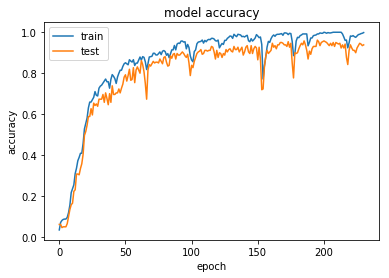

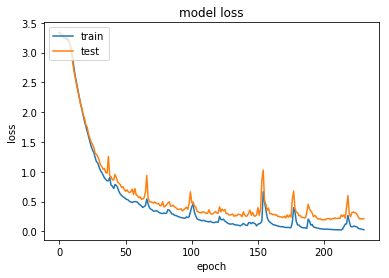

In [15]:
# summarize history for accuracy
plt.plot(GRURef_Hist.history['acc'])
plt.plot(GRURef_Hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(GRURef_Hist.history['loss'])
plt.plot(GRURef_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()